<a href="https://colab.research.google.com/github/vijaygwu/robotics/blob/main/AI_Fabrication_to_Behavior_Synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Homework Notebook: AI closes the fabrication → behavior loop (Synthetic Data)

This notebook is **self-contained**:
- It generates a **synthetic dataset** for extrusion-based, multi-material soft robotics additive manufacturing (AM).
- It trains and compares **three models** (Ridge, RandomForest, small MLP) to predict a behavior metric.
- It performs a simple **inverse design** search: “Find fabrication settings that hit a target behavior.”
- It adds **uncertainty** via a bootstrapped ensemble.

> **Learning goal:** connect *fabrication parameters* → *mechanical behavior* and show how AI can suggest “what to print next.”


In [1]:

import numpy as np
import pandas as pd

def make_softrobot_fab_dataset(n=1500, seed=42):
    """
    Synthetic dataset mimicking fabrication parameters -> mechanical behavior.
    Columns are plausible for extrusion-based, multi-material soft robotics AM.
    Targets:
      - bend_angle_deg (higher = more bending)
      - stiffness_N_per_mm (higher = stiffer)
      - failure_cycles (higher = more durable under cyclic loading)
    """
    rng = np.random.default_rng(seed)

    # Fabrication / process parameters
    nozzle_diam_mm   = rng.choice([0.25, 0.4, 0.6], size=n, p=[0.25, 0.6, 0.15])
    layer_height_mm  = rng.uniform(0.08, 0.35, size=n)
    print_speed_mm_s = rng.uniform(10, 120, size=n)
    infill_frac      = rng.uniform(0.05, 0.9, size=n)      # 0-1
    curing_temp_C    = rng.uniform(20, 120, size=n)
    curing_time_min  = rng.uniform(5, 90, size=n)

    # Multi-material mix (A = soft elastomer, B = stiff elastomer, C = conductive/sensing filler)
    material_B_ratio = rng.uniform(0.0, 0.7, size=n)  # stiff fraction
    filler_ratio     = rng.uniform(0.0, 0.15, size=n) # conductive filler
    material_A_ratio = np.clip(1.0 - material_B_ratio - filler_ratio, 0.05, 1.0)

    # Geometry descriptors
    channel_area_mm2 = rng.uniform(0.5, 12.0, size=n)   # pneumatic channel cross-section
    wall_thickness_mm= rng.uniform(0.6, 4.0, size=n)
    aspect_ratio     = rng.uniform(1.0, 12.0, size=n)   # length/width of actuator beam

    # A few "environment / mission" descriptors (to set context for design)
    expected_temp_C  = rng.uniform(-20, 80, size=n)
    rad_kGy          = rng.exponential(scale=0.15, size=n)  # mostly low radiation, some higher tails

    # ---- Hidden physics-ish relationships (nonlinear, coupled) ----
    # Effective stiffness driver: more stiff material, more infill, thicker walls, lower channel area,
    # but also affected by curing (under/over cure reduces performance).
    cure_opt_temp = 70.0
    cure_opt_time = 35.0
    cure_quality = np.exp(-((curing_temp_C - cure_opt_temp)/25.0)**2) * np.exp(-((curing_time_min - cure_opt_time)/25.0)**2)
    cure_quality = 0.6 + 0.7*cure_quality  # floor + peak

    # Print defects rise with high speed + large layer height relative to nozzle
    lh_over_noz = layer_height_mm / nozzle_diam_mm
    defect_index = (print_speed_mm_s/120.0)**1.3 * np.clip(lh_over_noz - 0.25, 0, None)**1.2
    defect_index = np.clip(defect_index, 0, 2.5)

    # Temperature + radiation degrade durability (more for higher filler_ratio)
    env_degrade = (0.004*np.clip(expected_temp_C-25, 0, None) +
                   1.8*rad_kGy*(0.6 + 2.0*filler_ratio))

    # Stiffness (N/mm)
    stiffness = (
        0.9
        + 7.5*material_B_ratio
        + 5.0*infill_frac
        + 0.9*(wall_thickness_mm/2.0)
        - 0.25*channel_area_mm2
        + 0.15*(aspect_ratio/4.0)
    ) * cure_quality * (1.0 - 0.18*defect_index)

    # Bend angle (deg): bigger channels + longer aspect ratio bend more;
    # higher stiffness and thicker walls bend less; more soft material increases bending;
    # printing defects add variability (sometimes more bend due to weak spots).
    bend_angle = (
        18
        + 5.2*np.log1p(channel_area_mm2)
        + 3.1*np.sqrt(aspect_ratio)
        + 12.0*material_A_ratio
        - 8.5*material_B_ratio
        - 3.2*(wall_thickness_mm-1.0)
        - 4.8*infill_frac
        + 6.0*(defect_index-0.3)
    ) * (0.85 + 0.25*cure_quality)

    # Failure cycles: increases with cure quality, moderate stiffness,
    # lower defect index, lower environment degrade; very high stiffness can be brittle.
    brittleness = np.clip(stiffness - 10.5, 0, None)
    failure_cycles = (
        1200
        + 1400*cure_quality
        + 900*np.tanh(0.35*stiffness)
        - 700*defect_index
        - 950*env_degrade
        - 280*brittleness
        + 120*(1.0 - filler_ratio/0.15)
    )

    # Add noise (heteroscedastic)
    bend_noise = rng.normal(0, 2.2 + 2.0*defect_index, size=n)
    stiff_noise = rng.normal(0, 0.35 + 0.25*defect_index, size=n)
    fail_noise  = rng.normal(0, 60 + 80*defect_index + 40*env_degrade, size=n)

    bend_angle = bend_angle + bend_noise
    stiffness  = stiffness + stiff_noise
    failure_cycles = np.maximum(50, failure_cycles + fail_noise)

    df = pd.DataFrame({
        "nozzle_diam_mm": nozzle_diam_mm,
        "layer_height_mm": layer_height_mm,
        "print_speed_mm_s": print_speed_mm_s,
        "infill_frac": infill_frac,
        "curing_temp_C": curing_temp_C,
        "curing_time_min": curing_time_min,
        "material_A_ratio": material_A_ratio,
        "material_B_ratio": material_B_ratio,
        "filler_ratio": filler_ratio,
        "channel_area_mm2": channel_area_mm2,
        "wall_thickness_mm": wall_thickness_mm,
        "aspect_ratio": aspect_ratio,
        "expected_temp_C": expected_temp_C,
        "rad_kGy": rad_kGy,
        "bend_angle_deg": bend_angle,
        "stiffness_N_per_mm": stiffness,
        "failure_cycles": failure_cycles
    })

    # Insert a small amount of missingness to mimic real logs
    miss_cols = ["layer_height_mm", "print_speed_mm_s", "curing_temp_C", "channel_area_mm2"]
    for c in miss_cols:
        m = rng.random(n) < 0.02
        df.loc[m, c] = np.nan

    return df

df = make_softrobot_fab_dataset(n=1800, seed=7)
df.head()


,nozzle_diam_mm,layer_height_mm,print_speed_mm_s,infill_frac,curing_temp_C,curing_time_min,material_A_ratio,material_B_ratio,filler_ratio,channel_area_mm2,wall_thickness_mm,aspect_ratio,expected_temp_C,rad_kGy,bend_angle_deg,stiffness_N_per_mm,failure_cycles
0,0.40,0.239933,52.986907,0.497438,117.655041,27.230430,0.223526,0.657868,0.118606,11.861929,0.935848,4.029897,-1.862237,0.048844,31.769871,3.605612,2593.731175
1,0.60,0.229985,43.369924,0.738503,44.474940,39.091624,0.762004,0.140132,0.097863,4.302489,3.692882,7.827250,45.188816,0.156527,30.776872,5.851043,3072.344028
2,0.40,0.267297,94.339688,0.701490,44.630368,61.093789,0.274889,0.682862,0.042249,2.481117,1.330092,3.323537,5.397683,0.191182,25.063610,6.454503,2770.399715
3,0.25,0.162847,102.612481,0.619657,56.586799,80.634532,0.460774,0.435001,0.104225,1.918418,2.585761,7.643618,29.602642,0.324920,25.774923,4.608359,2205.936706
4,0.40,0.183722,106.513842,0.059307,43.996621,74.370492,0.484677,0.429578,0.085746,11.856688,2.766668,3.899808,-7.912000,0.049481,31.120790,2.096559,2298.234985


## Model training: predict behavior from fabrication parameters

In [4]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Features / targets
target = "bend_angle_deg"  # you can switch to stiffness_N_per_mm or failure_cycles
feature_cols = [c for c in df.columns if c not in ["bend_angle_deg", "stiffness_N_per_mm", "failure_cycles"]]

X = df[feature_cols]
y = df[target]

# Train/val split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = feature_cols

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features)
    ],
    remainder="drop"
)

models = {
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=350, random_state=42, n_jobs=-1, max_depth=None, min_samples_leaf=2
    ),
    "MLP": MLPRegressor(
        hidden_layer_sizes=(64, 64),
        activation="relu",
        alpha=1e-4,
        learning_rate_init=2e-3,
        max_iter=800,
        random_state=42
    )
}

def evaluate(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    mae = mean_absolute_error(y_te, pred)
    rmse = np.sqrt(mean_squared_error(y_te, pred)) # Fix: Removed 'squared=False' and added np.sqrt
    r2 = r2_score(y_te, pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

results = {}
fitted = {}

for name, est in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", est)])
    results[name] = evaluate(pipe, X_train, y_train, X_test, y_test)
    fitted[name] = pipe

pd.DataFrame(results).T.sort_values("RMSE")


,MAE,RMSE,R2
Ridge,2.618295,3.341313,0.800595
RandomForest,2.826480,3.558516,0.773828
MLP,2.952897,3.667506,0.759761


## Diagnostics: residuals and (optional) feature importance

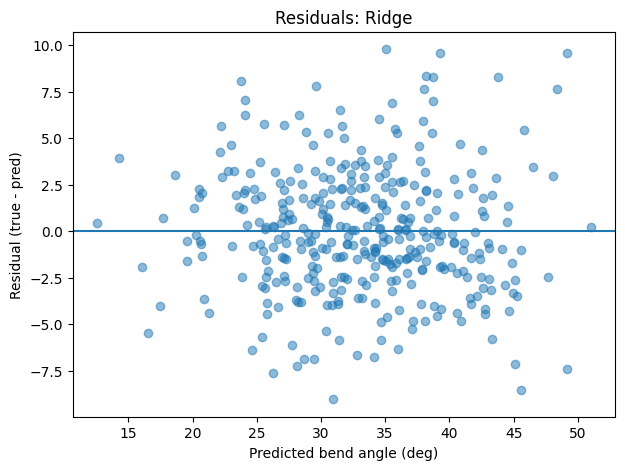

Feature importances shown only when best model is RandomForest (you can still inspect others).


In [5]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Residual plot for best model
best_name = pd.DataFrame(results).T.sort_values("RMSE").index[0]
best_model = fitted[best_name]

pred = best_model.predict(X_test)
resid = y_test.values - pred

plt.figure(figsize=(7,5))
plt.scatter(pred, resid, alpha=0.5)
plt.axhline(0)
plt.xlabel("Predicted bend angle (deg)")
plt.ylabel("Residual (true - pred)")
plt.title(f"Residuals: {best_name}")
plt.show()

# Feature importance (if best is RF)
if best_name == "RandomForest":
    rf = best_model.named_steps["model"]
    importances = rf.feature_importances_
    order = np.argsort(importances)[::-1][:12]

    plt.figure(figsize=(8,5))
    plt.bar(range(len(order)), importances[order])
    plt.xticks(range(len(order)), np.array(feature_cols)[order], rotation=45, ha="right")
    plt.ylabel("Importance")
    plt.title("Top Feature Importances (RandomForest)")
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances shown only when best model is RandomForest (you can still inspect others).")


## Inverse design: search for fabrication settings that hit a target behavior

In [6]:

import numpy as np
import pandas as pd

best_name = pd.DataFrame(results).T.sort_values("RMSE").index[0]
best_model = fitted[best_name]
print("Best model:", best_name)

# --- Simple "inverse design": search fabrication parameters to hit a target bend angle ---
# We'll do a constrained random search over plausible parameter ranges.
rng = np.random.default_rng(0)

target_bend = 55.0  # degrees
target_tol = 3.0    # acceptable error band
min_stiffness = 4.0 # optional: keep stiffness above a threshold

# We'll also fit a stiffness model so we can enforce a stiffness constraint during search
# (This mimics multi-objective design: hit bend target while staying stiff enough.)
stiff_target = "stiffness_N_per_mm"
y_stiff = df[stiff_target]
X_tr, X_te, y_tr, y_te = train_test_split(df[feature_cols], y_stiff, test_size=0.2, random_state=42)

stiff_model = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(n_estimators=350, random_state=42, n_jobs=-1, min_samples_leaf=2))
])
stiff_model.fit(X_tr, y_tr)

def sample_candidates(m=5000):
    cand = {}
    cand["nozzle_diam_mm"] = rng.choice([0.25, 0.4, 0.6], size=m, p=[0.25, 0.6, 0.15])
    cand["layer_height_mm"] = rng.uniform(0.08, 0.35, size=m)
    cand["print_speed_mm_s"] = rng.uniform(10, 120, size=m)
    cand["infill_frac"] = rng.uniform(0.05, 0.9, size=m)
    cand["curing_temp_C"] = rng.uniform(20, 120, size=m)
    cand["curing_time_min"] = rng.uniform(5, 90, size=m)

    cand["material_B_ratio"] = rng.uniform(0.0, 0.7, size=m)
    cand["filler_ratio"] = rng.uniform(0.0, 0.15, size=m)
    cand["material_A_ratio"] = np.clip(1.0 - cand["material_B_ratio"] - cand["filler_ratio"], 0.05, 1.0)

    cand["channel_area_mm2"] = rng.uniform(0.5, 12.0, size=m)
    cand["wall_thickness_mm"] = rng.uniform(0.6, 4.0, size=m)
    cand["aspect_ratio"] = rng.uniform(1.0, 12.0, size=m)

    cand["expected_temp_C"] = rng.uniform(-20, 80, size=m)
    cand["rad_kGy"] = rng.exponential(scale=0.15, size=m)

    return pd.DataFrame(cand)[feature_cols]

cands = sample_candidates(8000)
pred_bend = best_model.predict(cands)
pred_stiff = stiff_model.predict(cands)

score = np.abs(pred_bend - target_bend)
ok = (score <= target_tol) & (pred_stiff >= min_stiffness)

solutions = cands.loc[ok].copy()
solutions["pred_bend_deg"] = pred_bend[ok]
solutions["pred_stiff_N_per_mm"] = pred_stiff[ok]
solutions["abs_error"] = score[ok]

print("Found solutions:", len(solutions))
solutions.sort_values(["abs_error", "pred_stiff_N_per_mm"], ascending=[True, False]).head(10)


Best model: Ridge
Found solutions: 0


,nozzle_diam_mm,layer_height_mm,print_speed_mm_s,infill_frac,curing_temp_C,curing_time_min,material_A_ratio,material_B_ratio,filler_ratio,channel_area_mm2,wall_thickness_mm,aspect_ratio,expected_temp_C,rad_kGy,pred_bend_deg,pred_stiff_N_per_mm,abs_error


## Uncertainty: bootstrapped prediction intervals (quick + practical)

In [7]:

import numpy as np
import pandas as pd

# --- Quick uncertainty via bootstrapped ensembles (for bend_angle) ---
# We'll bootstrap the training data, fit multiple RF models, and look at prediction intervals.
from sklearn.base import clone

base_rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=250, random_state=0, n_jobs=-1, min_samples_leaf=2
    ))
])

B = 25
rng = np.random.default_rng(123)

X_train_full = df[feature_cols]
y_train_full = df["bend_angle_deg"]

# pick a few test points to show uncertainty
test_points = df[feature_cols].sample(8, random_state=1)

preds = []
n = len(X_train_full)

for b in range(B):
    idx = rng.integers(0, n, size=n)  # bootstrap sample indices
    Xb = X_train_full.iloc[idx]
    yb = y_train_full.iloc[idx]
    m = clone(base_rf)
    m.fit(Xb, yb)
    preds.append(m.predict(test_points))

preds = np.vstack(preds)  # [B, n_points]
mean = preds.mean(axis=0)
lo = np.quantile(preds, 0.1, axis=0)
hi = np.quantile(preds, 0.9, axis=0)

out = test_points.copy()
out["pred_mean_deg"] = mean
out["pred_p10_deg"] = lo
out["pred_p90_deg"] = hi
out


,nozzle_diam_mm,layer_height_mm,print_speed_mm_s,infill_frac,curing_temp_C,curing_time_min,material_A_ratio,material_B_ratio,filler_ratio,channel_area_mm2,wall_thickness_mm,aspect_ratio,expected_temp_C,rad_kGy,pred_mean_deg,pred_p10_deg,pred_p90_deg
1462,0.25,0.148795,56.700382,0.347724,71.076187,44.800631,0.687421,0.247849,0.064730,2.014712,2.309221,8.606473,37.874457,0.391449,34.272353,32.901906,35.540982
510,0.40,0.139735,25.082094,0.847551,65.557790,49.591502,0.470889,0.511410,0.017700,8.403539,1.602943,7.544855,5.035224,0.066418,35.543718,34.508494,36.189852
612,0.60,NaN,90.634584,0.825309,98.166490,70.326341,0.601173,0.285646,0.113181,7.044528,1.161743,3.366958,67.711963,0.357278,34.656653,33.597325,36.065845
1322,0.25,0.174206,54.865549,0.620470,59.226826,76.506132,0.659537,0.308397,0.032066,2.996973,3.759923,8.619754,64.648837,0.015042,28.682891,27.200239,29.919064
993,0.60,0.300098,37.065200,0.332738,101.631449,84.679752,0.901127,0.043140,0.055733,6.905587,3.464059,3.857906,19.205599,0.177914,33.984591,32.717941,36.049981
190,0.25,0.086452,16.570304,0.720298,66.918382,55.390103,0.445504,0.460900,0.093596,5.639522,3.657769,5.047055,13.320709,0.230602,24.530935,23.834366,25.014246
1716,0.40,0.326371,115.899225,0.323210,61.602977,62.618067,0.492988,0.363095,0.143917,5.818233,0.887262,1.794432,28.475494,0.090097,35.456347,34.235027,36.369187
1048,0.40,0.344464,40.087233,0.859109,114.816593,62.250066,0.758993,0.097063,0.143944,4.108523,3.392258,11.886146,49.654967,0.052170,34.761021,33.908273,36.208559



## Optional - What you should change (student knobs)

Try at least **two** of the following:
1. Change `target` to predict **stiffness** or **failure_cycles** instead of bend angle.
2. Add/remove features (e.g., remove environment variables and see if generalization worsens).
3. Tighten design constraints in the inverse design step (e.g., higher min stiffness).
4. Change model hyperparameters and re-run.

**Deliverable:** Submit the notebook + 1 short paragraph answering:
- Which features mattered most?
- Which model generalized best?
- What fabrication parameters would you print next (and why)?
